# Vehicle Routing Problem with Time Windows

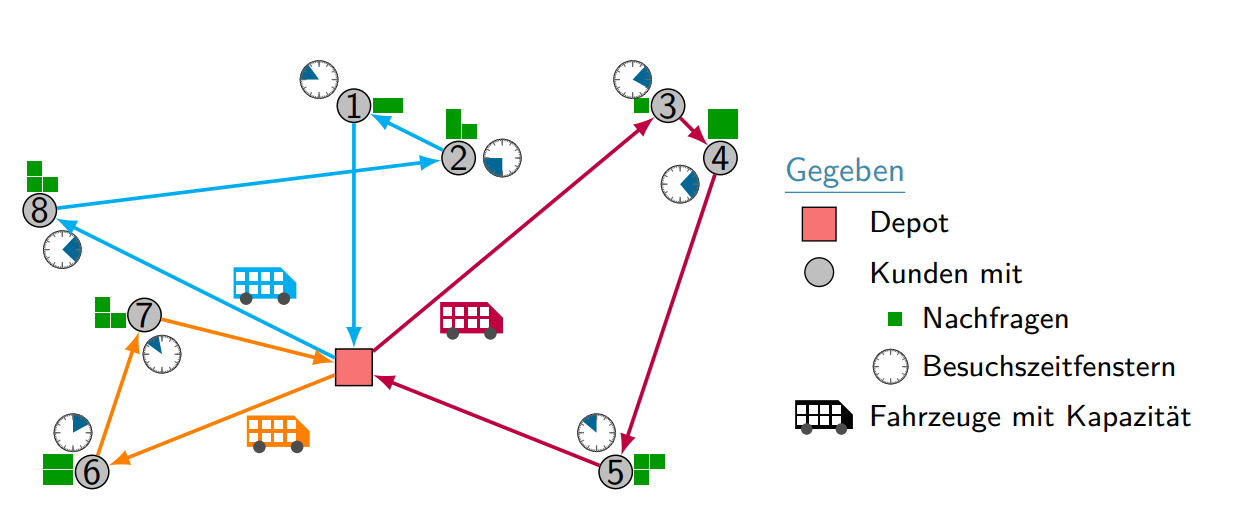

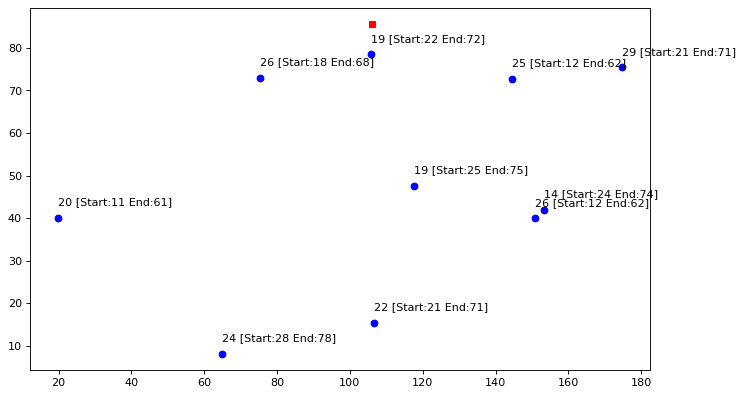

In [79]:
import gurobipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Generation

#Input Data
rnd = np.random
n = 10
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100
N = [i for i in range(1,n+1)]
V = [0] + N
A = [(i,j) for i in V for j in V if i != j]
c = {(i,j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i,j in A}
Q = 50
q = {i: rnd.randint(10,30) for i in N}


#Extension of the VRP for VRPTW
a = {i: rnd.randint(10,30) for i in V}
b = {i: a[i] + 50 for i in V}
t = {(i,j): round(np.hypot(xc[i]-xc[j], yc[i]-yc[j]),0) for i,j in A}

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c = 'b')

# +1 because first node is depot
for i, txt in enumerate(q):
    plt.annotate(f"{q[txt]} [Start:{a[i]} End:{b[i]}]" , (xc[i+1], yc[i+1]+3))


In [62]:
t

{(0, 1): 32.0,
 (0, 2): 44.0,
 (0, 3): 28.0,
 (0, 4): 122.0,
 (0, 5): 37.0,
 (0, 6): 41.0,
 (0, 7): 117.0,
 (0, 8): 132.0,
 (0, 9): 49.0,
 (0, 10): 137.0,
 (1, 0): 32.0,
 (1, 2): 67.0,
 (1, 3): 11.0,
 (1, 4): 93.0,
 (1, 5): 16.0,
 (1, 6): 10.0,
 (1, 7): 86.0,
 (1, 8): 102.0,
 (1, 9): 36.0,
 (1, 10): 107.0,
 (2, 0): 44.0,
 (2, 1): 67.0,
 (2, 3): 58.0,
 (2, 4): 160.0,
 (2, 5): 79.0,
 (2, 6): 78.0,
 (2, 7): 148.0,
 (2, 8): 168.0,
 (2, 9): 57.0,
 (2, 10): 175.0,
 (3, 0): 28.0,
 (3, 1): 11.0,
 (3, 2): 58.0,
 (3, 4): 103.0,
 (3, 5): 27.0,
 (3, 6): 21.0,
 (3, 7): 92.0,
 (3, 8): 111.0,
 (3, 9): 27.0,
 (3, 10): 117.0,
 (4, 0): 122.0,
 (4, 1): 93.0,
 (4, 2): 160.0,
 (4, 3): 103.0,
 (4, 5): 85.0,
 (4, 6): 83.0,
 (4, 7): 40.0,
 (4, 8): 13.0,
 (4, 9): 114.0,
 (4, 10): 14.0,
 (5, 0): 37.0,
 (5, 1): 16.0,
 (5, 2): 79.0,
 (5, 3): 27.0,
 (5, 4): 85.0,
 (5, 6): 14.0,
 (5, 7): 85.0,
 (5, 8): 95.0,
 (5, 9): 52.0,
 (5, 10): 100.0,
 (6, 0): 41.0,
 (6, 1): 10.0,
 (6, 2): 78.0,
 (6, 3): 21.0,
 (6, 4): 83.0,
 

min! $\sum_{i,j \in \mathcal{A}}  c_{i,j} \cdot x_{i,j}$ 

(1) $\sum_{j \in \mathcal{V}, j \neq i}  x_{i,j} = 1 \;\; \forall i \in N $ 

(2) $\sum_{j \in \mathcal{V}, j \neq i}  x_{i,j} = 1 \;\; \forall j \in N $ 

(3) $\sum_{j \in \mathcal{V}, j \neq i, j = 0}  x_{i,j} \leq |K|$

(4) $u_{i} - u_j + Q \cdot x_{i,j} \leq Q - q_{j}  \,\,\, \forall i,j \in \mathcal{A} $

(5) $q_i \leq u_i \leq Q \; \forall i \in N$

(6) $T_{i} - T_{j} + M \cdot x_{i,j} \leq M - t_{i,j} \,\,\, \forall i,j \in \mathcal{A} $

(7) $a_i \leq T_i \leq b_i$

(8) $x_{i,j} \in {0,1}$

In [63]:
from gurobipy import Model, GRB, quicksum

mdl = Model("CVRP")
mdl.setParam('TimeLimit', 30)

x = mdl.addVars(A, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)
T = mdl.addVars(N, vtype=GRB.CONTINUOUS)

mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[a]*c[a] for a in A))
mdl.addConstrs(quicksum(x[i,j] for j in V if j!=i)== 1 for i in N);
mdl.addConstrs(quicksum(x[i,j] for i in V if j!=i)== 1 for j in N);
mdl.addConstrs((x[i,j] == 1) >> (u[i] + q[i] == u[j])
              for i,j in A if i!=0 and j!=0);
mdl.addConstrs(u[i] >= q[i] for  i in N);
mdl.addConstrs(u[i] <= Q for i in N);

mdl.addConstrs((x[i,j] == 1) >> (T[i] + t[i,j] == T[j])
              for i,j in A if i!=0 and j!=0);

mdl.addConstrs(T[i] >= a[i] for  i in N);
mdl.addConstrs(T[i] <= b[i] for i in N);

mdl.optimize()

Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 60 rows, 130 columns and 240 nonzeros
Model fingerprint: 0x54bb6f61
Model has 180 general constraints
Variable types: 20 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
  GenCon rhs range [1e+01, 2e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 37 rows and 0 columns
Presolve removed 0 rows and 86 columns
Presolve time: 0.08s
Presolved: 97 rows, 44 columns, 439 nonzeros
Variable types: 25 continuous, 19 integer (19 binary)
Found heuristic solution: objective 975.4460607

Root relaxation: objective 7.250353e+02, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

In [64]:
a

{0: 24, 1: 15, 2: 20, 3: 28, 4: 17, 5: 11, 6: 29, 7: 14, 8: 13, 9: 16, 10: 13}

In [65]:
b

{0: 74, 1: 65, 2: 70, 3: 78, 4: 67, 5: 61, 6: 79, 7: 64, 8: 63, 9: 66, 10: 63}

In [66]:
len(N)

10

In [67]:
len(a)

11

In [68]:
active_arcs = [a for a in A if x[a].x > 0.99]

#Coloring every unique route with a different color

def FindEdgeByStartingNode(Node, li):
    for e in li:
        if(e[0] == Node):
            return e

def GetRouteRemoveEdgesFromLi(startingEdge, li): 
    x = startingEdge
    tour = []
    tour.append(startingEdge) 
    while(True):
        x = FindEdgeByStartingNode(x[1], li)
        tour.append(x)
        
        if(x[1] == 0):
            break            
        #li.pop(li.index(x))   
    return tour

numberOfRoutes = 0
for e in active_arcs:
    if(e[0] == 0):
        numberOfRoutes+=1
routes = []

for i in range(0,numberOfRoutes+1):
    routes.append(GetRouteRemoveEdgesFromLi(active_arcs[i],active_arcs))
    #we get error message when amoutn of routes is less than 3
    
active_arcs = [a for a in A if x[a].x > 0.99]

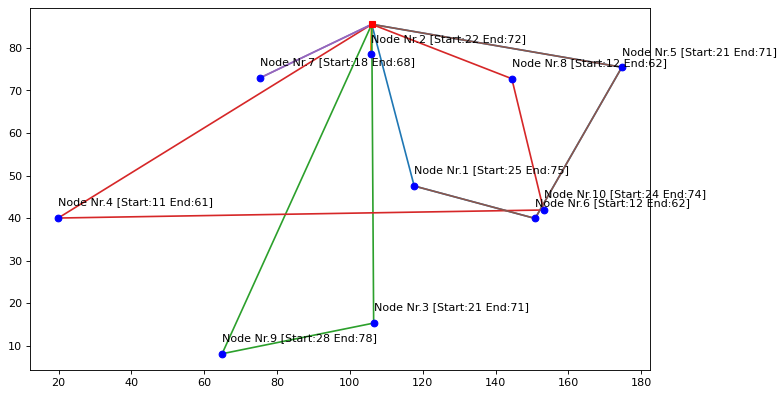

In [82]:
color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

plt.figure(figsize=(10, 6), dpi=80) 
for idx, route in enumerate(routes):
    for i,j in route:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=f'{color[idx]}', zorder=0)
  
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

# +1 because first node is depot
for i, txt in enumerate(N):
    plt.annotate(f"Node Nr.{txt} [Start:{a[i]} End:{b[i]}]" , (xc[i+1], yc[i+1]+3))


In [77]:
df = pd.DataFrame(data=routes)
df["color"]  = color[:df.shape[0]]
df

,0,1,2,3,color
0,"(0, 1)","(1, 6)","(6, 5)","(5, 0)",tab:blue
1,"(0, 2)","(2, 0)",None,None,tab:orange
2,"(0, 3)","(3, 9)","(9, 0)",None,tab:green
3,"(0, 4)","(4, 10)","(10, 8)","(8, 0)",tab:red
4,"(0, 7)","(7, 0)",None,None,tab:purple
5,"(1, 6)","(6, 5)","(5, 0)",None,tab:brown
